# MAIN for gmm_diag.stan

In [1]:
import numpy as np
import pystan
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')
import itertools
import datetime
import os, sys, subprocess, os.path, shutil
FNULL = open(os.devnull, 'w')
def execute(command):    
    popen = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    lines_iterator = iter(popen.stdout.readline, b"")
    for line in lines_iterator:
        print(line), # yield line

In [3]:
# Run NUTS and ADVI using these commands

nuts_execution = "./gmm_diag sample save_warmup=1 data file=training.data.R "
nuts_execution += "output file=output_nuts.csv random seed=1"

advi_execution = "./gmm_diag variational eta_adagrad=0.5 eval_elbo=10 tol_rel_obj=0.015 "
advi_execution += "data file=training.data.R "
advi_execution += "output file=output_mf.csv diagnostic_file=elbo_mf.csv random seed=1"

subprocess.call('rm -rf *.csv', shell=True, stdout=FNULL)
execute(nuts_execution)
execute(advi_execution)

 method = sample (Default)
   sample
     num_samples = 1000 (Default)
     num_warmup = 1000 (Default)
     save_warmup = 1
     thin = 1 (Default)
     adapt
       engaged = 1 (Default)
       gamma = 0.050000000000000003 (Default)
       delta = 0.80000000000000004 (Default)
       kappa = 0.75 (Default)
       t0 = 10 (Default)
       init_buffer = 75 (Default)
       term_buffer = 50 (Default)
       window = 25 (Default)
     algorithm = hmc (Default)
       hmc
         engine = nuts (Default)
           nuts
             max_depth = 10 (Default)
         metric = diag_e (Default)
         stepsize = 1 (Default)
         stepsize_jitter = 0 (Default)
 id = 0 (Default)
 data
   file = training.data.R
 init = 2 (Default)
 random
   seed = 1
 output
   file = output_nuts.csv
   diagnostic_file =  (Default)
   refresh = 100 (Default)


Gradient evaluation took 0.002049 seconds
1000 transitions using 10 leapfrog steps per transition would take 20.49 seconds.
Adjust your expectations

In [4]:
# Define log_pred Stan program
execution_string = "./gmm_diag_logpred sample algorithm=fixed_param num_samples=1 "
execution_string += "data file=logpred.data.R output file=output_logpred.csv"  

In [5]:
# Make copies of timing CSV files because the log_pred calculations will overwrite them.
shutil.copy('warmup_timing.csv', 'warmup_timing_ORIG.csv')
shutil.copy('sample_timing.csv', 'sample_timing_ORIG.csv')

In [6]:
# Form the basic structure of the held-out logpredictive "dataset"
testing = pystan.misc.read_rdump('training.data.R')

datadict = {}

block_size = 25 # this has to match `num_intermediate_samples` in `advi.hpp`
datadict['S']         = block_size
datadict['K']         = testing['K']
datadict['D']         = testing['D']
datadict['N']         = testing['N']
datadict['y_heldout'] = testing['y'] 

In [7]:
## NUTS 

# Get timing results
warmup_timing = np.genfromtxt('warmup_timing_ORIG.csv', delimiter=',')[:,1]
sample_timing = np.genfromtxt('sample_timing_ORIG.csv', delimiter=',')[:,1]
sample_timing = sample_timing + warmup_timing[-1] # stan resets the timer
full_timing_nuts = np.concatenate([warmup_timing, sample_timing])

# The first 6 columns are useless for us
samples = np.genfromtxt('output_nuts.csv', delimiter=',')[1:,6:]
N_test = samples.shape[0]
K = testing['K']
D = testing['D']
theta   = samples[:,0:K]
mu      = np.reshape(samples[:, K:K+K*D], (N_test,K,D), order='F')
sigma   = np.reshape(samples[:, K+K*D:],  (N_test,K,D), order='F')

ave_log_pred_nuts = np.zeros(samples.shape[0]/block_size);
timing_nuts = np.zeros(samples.shape[0]/block_size);

for i in range(samples.shape[0]/block_size):
    print "Processing iterations",
    print i*block_size,
    print "to",
    print (i+1)*block_size,
    
    datadict['theta'] = theta[i*block_size:(i+1)*block_size, :]
    datadict['mu']    = np.swapaxes(mu[i*block_size:(i+1)*block_size, :, :], 0, 1)
    datadict['sigma'] = np.swapaxes(sigma[i*block_size:(i+1)*block_size, :, :], 0, 1)
    # hack to make sure simplexes numerically sums up to 1
    datadict['theta'][:,0] += 1.0 - np.sum(datadict['theta'],axis=1)
    
    pystan.misc.stan_rdump(datadict, 'logpred.data.R')
    
    subprocess.call(execution_string, shell=True, stdout=FNULL)
    
    ave_log_pred_nuts[i] = np.genfromtxt('output_logpred.csv', delimiter=',')[1,-1]
    timing_nuts[i]       = full_timing_nuts[(i+1)*block_size - 1]
    
    print "\tave_log_pred: ",
    print "{:>8.1f}".format(ave_log_pred_nuts[i]),
    print "at",
    print timing_nuts[i] 

Processing iterations 0 to 25 	ave_log_pred:      -8.9 at 3.1496
Processing iterations 25 to 50 	ave_log_pred:      -8.4 at 11.1335
Processing iterations 50 to 75 	ave_log_pred:      -8.4 at 16.3878
Processing iterations 75 to 100 	ave_log_pred:      -8.4 at 22.6683
Processing iterations 100 to 125 	ave_log_pred:      -8.4 at 23.0548
Processing iterations 125 to 150 	ave_log_pred:      -8.4 at 23.4815
Processing iterations 150 to 175 	ave_log_pred:      -8.4 at 23.8751
Processing iterations 175 to 200 	ave_log_pred:      -8.4 at 24.2119
Processing iterations 200 to 225 	ave_log_pred:      -8.4 at 24.5266
Processing iterations 225 to 250 	ave_log_pred:      -8.4 at 24.8849
Processing iterations 250 to 275 	ave_log_pred:      -8.4 at 25.3881
Processing iterations 275 to 300 	ave_log_pred:      -8.4 at 25.7621
Processing iterations 300 to 325 	ave_log_pred:      -8.4 at 26.1455
Processing iterations 325 to 350 	ave_log_pred:      -8.4 at 26.4604
Processing iterations 350 to 375 	ave_log_p

In [8]:
## ADVI
elbo = np.genfromtxt('elbo_mf.csv', delimiter=',')
advi_iterations = np.array(elbo[1:,0], dtype='int')
timing_advi = elbo[1:,1]

ave_log_pred_advi = np.zeros_like(timing_advi);

counter = 0;
for i in advi_iterations:
    print "Processing iteration " + str(i),
    
    samples = np.genfromtxt('intermediate_variational_samples_'+str(i)+'.csv', delimiter=',')[:,1:]

    N_test = samples.shape[0]
    K = testing['K']
    D = testing['D']

    theta   = samples[:,0:K]
    mu      = np.reshape(samples[:, K:K+K*D], (N_test,K,D), order='F')
    sigma   = np.reshape(samples[:, K+K*D:],  (N_test,K,D), order='F')
    
    datadict['theta'] = theta
    datadict['mu']    = np.swapaxes(mu, 0, 1)
    datadict['sigma'] = np.swapaxes(sigma, 0, 1)
    # hack to make sure simplexes numerically sums up to 1
    datadict['theta'][:,0] += 1.0 - np.sum(datadict['theta'],axis=1)
    
    pystan.misc.stan_rdump(datadict, 'logpred.data.R')

    subprocess.call(execution_string, shell=True, stdout=FNULL)
    
    ave_log_pred_advi[counter] = np.genfromtxt('output_logpred.csv', delimiter=',')[1,-1]
    
    print "\tave_log_pred: ",
    print "{:>8.1f}".format(ave_log_pred_advi[counter]),
    print "at",
    print timing_advi[counter] 
    
    counter = counter + 1

Processing iteration 0 	ave_log_pred:     -56.9 at 0.161838
Processing iteration 10 	ave_log_pred:      -9.4 at 0.348537
Processing iteration 20 	ave_log_pred:      -8.5 at 0.535009
Processing iteration 30 	ave_log_pred:      -8.6 at 0.70565
Processing iteration 40 	ave_log_pred:      -8.5 at 0.883079
Processing iteration 50 	ave_log_pred:      -8.6 at 1.05464
Processing iteration 60 	ave_log_pred:      -8.5 at 1.2282
Processing iteration 70 	ave_log_pred:      -8.7 at 1.40945
Processing iteration 80 	ave_log_pred:      -8.7 at 1.57933
Processing iteration 90 	ave_log_pred:      -8.5 at 1.75375
Processing iteration 100 	ave_log_pred:      -8.4 at 1.9283
Processing iteration 110 	ave_log_pred:      -8.4 at 2.10983
Processing iteration 120 	ave_log_pred:      -8.6 at 2.28801
Processing iteration 130 	ave_log_pred:      -8.6 at 2.46359
Processing iteration 140 	ave_log_pred:      -8.6 at 2.63687
Processing iteration 150 	ave_log_pred:      -8.5 at 2.80877
Processing iteration 160 	ave_log

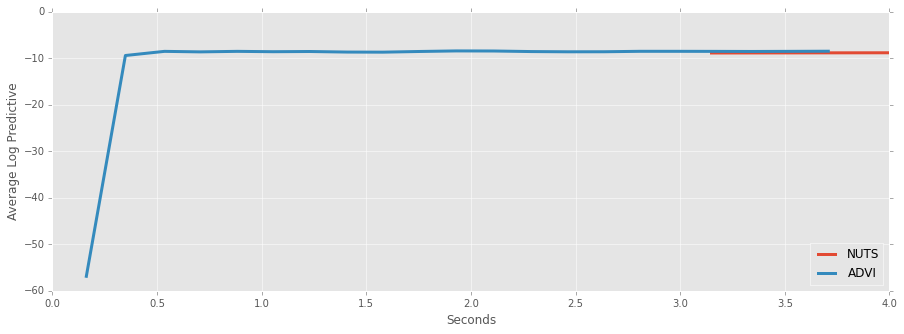

In [9]:
fi = plt.figure(figsize=(15,5))
ax = plt.subplot()
colors = itertools.cycle(plt.rcParams['axes.color_cycle'])

this_color = next(colors)
ax.plot(timing_nuts, ave_log_pred_nuts, lw=3, c=this_color, label='NUTS')

this_color = next(colors)
ax.plot(timing_advi, ave_log_pred_advi, lw=3, c=this_color, label='ADVI')

this_color = next(colors)
# ax.plot(timing_adsvi, ave_log_pred_adsvi, lw=3, c=this_color, label='STOCH ADVI')

ax.set_xlim([0,4])
# ax.set_xscale('log')

ax.set_xlabel('Seconds')
ax.set_ylabel('Average Log Predictive')
ax.legend(loc=4)
z=ax.plot()

plt.savefig('gmm_plot.pdf',format='pdf')

In [10]:
# Make a folder to stores results
results_directory = datetime.datetime.now().strftime("%Y-%m-%d_%a_%H-%M-%S")
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Move all results into folder    
source = os.listdir(".")
for files in source:
    if files.endswith(".csv") or files.endswith(".pdf"):
        shutil.move(files,results_directory)
        
# Copy programs, data, and this notebook
for files in source:
    if files.endswith(".stan") or files.endswith(".R") or files.endswith(".ipynb"):
        shutil.copy(files,results_directory)

# Remove logpred.data.R to keep things clean
os.remove("logpred.data.R")